## Seminar 6: More RecSys models!

In [6]:
import zipfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

### 1. Download dataset

Today we'll use LastFM dataset:

In [4]:
file_id = "1bQaLKqVXCEc_glE2UvohUd9yMaAiubEp"
destination = "lastfm.zip"
download_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(download_url, destination, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bQaLKqVXCEc_glE2UvohUd9yMaAiubEp
To: /Users/naumov-vladis/Desktop/recsys_course/seminar5_more_models/lastfm.zip
100%|██████████| 1.11M/1.11M [00:00<00:00, 10.8MB/s]


'lastfm.zip'

In [7]:
with zipfile.ZipFile(destination, "r") as zip_ref:
    zip_ref.extractall("lastfm")

It consists info about interactions between users and artists:

In [7]:
ratings = pd.read_csv(
    "lastfm/lastfm.inter",
    sep="\t",
    names=["user_id", "artist_id", "weight", "tag"],
    header=0,
)

In [8]:
ratings.head()

,user_id,artist_id,weight,tag
0,2,51,13883,NaN
1,2,52,11690,"chillout,downtempo,electronic,trip-hop,female ..."
2,2,53,11351,NaN
3,2,54,10300,NaN
4,2,55,8983,NaN


In [9]:
items_data = pd.read_csv(
    "lastfm/lastfm.item",
    sep="\t",
    names=["artist_id", "name", "url", "picture_url"],
    header=0,
)

In [10]:
items_data.head()

,artist_id,name,url,picture_url
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


### 2. EDA

Text(0.5, 0, '# interactions with artist')

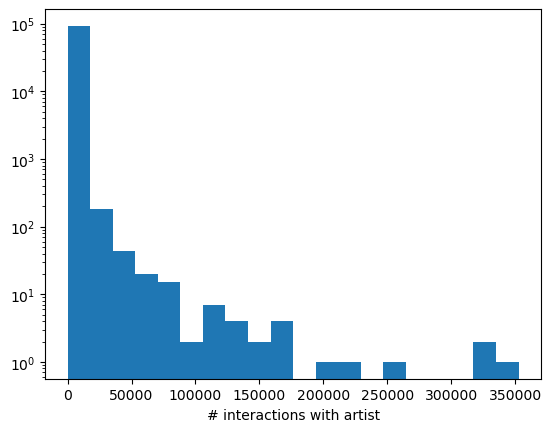

In [11]:
plt.hist(ratings["weight"], bins=20, log=True)
plt.xlabel("# interactions with artist")

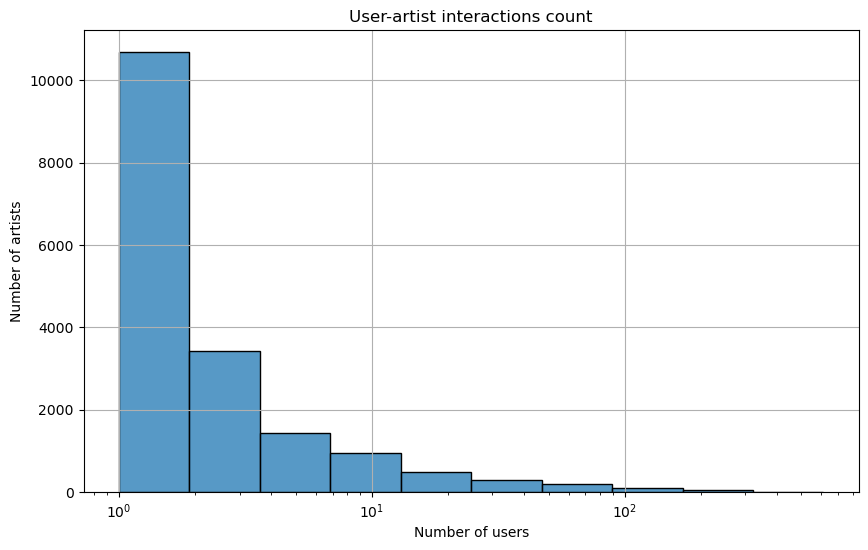

In [12]:
user_artist_counts = ratings.groupby("artist_id")["user_id"].count().values

plt.figure(figsize=(10, 6))
ax = sns.histplot(user_artist_counts, bins=10, log_scale=True)
ax.set(
    xlabel="Number of users",
    ylabel="Number of artists",
    title="User-artist interactions count",
)
ax.grid()

### 3. EASE

EASE (Embarrassingly Shallow Autoencoders) - linear model that is geared toward sparse data, in particular implicit
feedback data for recommender systems ([article](https://arxiv.org/pdf/1905.03375)).
Optimization task:

$$
\begin{aligned}
\min_{B} \quad & \|X - X B\|_F^2 + \lambda \|B\|_F^2 \\
\text{s.t.} \quad & \text{diag}(B) = 0
\end{aligned}
$$

where:
- $X \in \mathbb{R}^{|U| \times |I|}$ - the input matrix (**ratings matrix**),
- $B \in \mathbb{R}^{|I| \times |I|}$ is the learned parameter matrix (**item-item weight matrix**),
- $\| \cdot \|_F $ denotes the Frobenius norm,
- $\lambda$ is the regularization parameter.

Solution:

$$ \hat{B}_{ij} = \begin{cases} 0, \quad \text{if} \; i = j \\ -\frac{\hat{P}_ij}{\hat{P}_jj}, \quad \text{otherwise} \end{cases} ,$$

where $\hat{P} = (X^T X + \lambda I)^{-1}$.

In [13]:
class EASE:
    def __init__(self):
        self.user_enc = LabelEncoder()
        self.item_enc = LabelEncoder()

    def _get_users_and_items(self, df):
        users = self.user_enc.fit_transform(df.loc[:, "user_id"])
        items = self.item_enc.fit_transform(df.loc[:, "artist_id"])
        return users, items

    def fit(self, df, lambda_: float = 0.5, implicit=True):
        """
        df: pandas.DataFrame with columns user_id, item_id and (rating)
        lambda_: l2-regularization term
        implicit: if True, ratings are ignored and taken as 1, else normalized ratings are used
        """
        users, items = self._get_users_and_items(df)
        values = (
            np.ones(df.shape[0])
            if implicit
            else df["weight"].to_numpy() / df["weight"].max()
        )

        X = csr_matrix((values, (users, items)))
        self.X = X

        G = X.T.dot(X).toarray()
        diagIndices = np.diag_indices(G.shape[0])
        G[diagIndices] += lambda_
        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diagIndices] = 0

        self.B = B
        self.pred = X.dot(B)

    def predict(self, train, users, items, k):
        items = self.item_enc.transform(items)
        dd = train.loc[train.user_id.isin(users)]
        dd["ci"] = self.item_enc.transform(dd.artist_id)
        dd["cu"] = self.user_enc.transform(dd.user_id)
        g = dd.groupby("cu")

        user_preds = []
        for user, group in g:
            user_preds.append(
                self.predict_for_user(user, group, self.pred[user, :], items, k)
            )

        df = pd.concat(user_preds)
        df["artist_id"] = self.item_enc.inverse_transform(df["artist_id"])
        df["user_id"] = self.user_enc.inverse_transform(df["user_id"])
        return df

    @staticmethod
    def predict_for_user(user, group, pred, items, k):
        watched = set(group["ci"])
        candidates = [item for item in items if item not in watched]
        pred = np.take(pred, candidates)
        res = np.argpartition(pred, -k)[-k:]
        r = pd.DataFrame(
            {
                "user_id": [user] * len(res),
                "artist_id": np.take(candidates, res),
                "score": np.take(pred, res),
            }
        ).sort_values("score", ascending=False)
        return r

In [14]:
ease = EASE()

In [19]:
ease.fit(ratings, implicit=False)

In [20]:
users_to_predict = [2, 3, 4, 5]

all_items = ratings["artist_id"].unique()

k = 5  # Number of recommendations per user
recommendations = ease.predict(
    train=ratings, users=users_to_predict, items=all_items, k=k
)

/var/folders/0z/3w0j3xd529qf_7fc2w5t19nm3wgh24/T/ipykernel_34341/1053752243.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['ci'] = self.item_enc.transform(dd.artist_id)
/var/folders/0z/3w0j3xd529qf_7fc2w5t19nm3wgh24/T/ipykernel_34341/1053752243.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['cu'] = self.user_enc.transform(dd.user_id)


In [21]:
recommendations

,user_id,artist_id,score
3,2,289,0.002531
2,2,498,0.001123
4,2,511,0.001061
1,2,159,0.001007
0,2,292,0.000983
4,3,3502,0.000008
1,3,7079,0.000003
2,3,1109,0.000003
3,3,1975,0.000003
0,3,233,0.000003


In [18]:
recommendations

,user_id,artist_id,score
3,2,159,0.016983
4,2,238,0.016583
2,2,511,0.013600
1,2,1001,0.013472
0,2,298,0.012645
1,3,1736,0.002553
3,3,2605,0.002250
4,3,621,0.002237
2,3,196,0.001898
0,3,237,0.001754


In [22]:
def compute_mrr(iencoder, uencoder, train, preds, k=10):
    users = train["user_id"].unique()
    items = train["artist_id"].unique()

    sampled_users = np.random.choice(users, size=int(0.1 * len(users)), replace=False)

    mrr = 0
    for user in tqdm(sampled_users):
        true_items = train[train["user_id"] == user]["artist_id"].values

        user_index = uencoder.transform([user])[0]
        item_indices = iencoder.transform(items)

        ranked_items = np.argsort(-preds)[:k]  # Top-k ranked items

        for true_item in true_items:
            true_item_index = iencoder.transform([true_item])[0]
            if true_item_index in ranked_items:
                rank = np.where(ranked_items == true_item_index)[0][0] + 1
                mrr += 1 / rank
                break  # Only the first relevant item matters for MRR

    return mrr / len(users)

In [23]:
preds = ease.pred
compute_mrr(ease.item_enc, ease.user_enc, ratings, preds)

100%|██████████| 189/189 [05:30<00:00,  1.75s/it]


0.09989429175475686